## Demonstration of ∆LFE (mRNA folding bias) calculation

For explanation, see:

Peeri, M., Tuller, T. High-resolution modeling of the selection on local mRNA folding strength in coding sequences across the tree of life. Genome Biol **21**, *63* (2020). DOI: [10.1186/s13059-020-01971-y](https://doi.org/10.1186/s13059-020-01971-y)

### Input:
Fasta file containing CDS sequences

### Output:
The program will calculate the following properties, avereged over all given sequences (or a random sample of them if *sequenceSamplingFraction* > 1):
* ∆LFE (Local folding bias)
* Native LFE (Local folding energy)


### Requirements:
* RNAFold command-line program from the [Vienna RNA](https://www.tbi.univie.ac.at/RNA/) (for calculating MFE)
* BioPython (for reading CDS sequences, etc.)
* numpy (for calculating mean LFE...)
* Matplotlib (for plotting results)

In [16]:
# Configuration
geneticCode              = 11      # 11=Bacterial
windowWidth              = 40      # Width of window for LFE calculation (nt)
cdsSpan                  = 200     # Region over which to calculate ∆LFE profile (nt)
reference                = 'begin' # Reference point for ∆LFE profile. begin: start codon; end: stop codon
stepSize                 = 10      # Resolution of ∆LFE profile (nt)
randomizationDepth       = 10      # Number of random samples for (for each included CDS) for estimating random LFE
sequenceSamplingFraction = 5       # Speed up calculation by only including 1/N CDS sequences. If *sequenceSamplingFraction*==1, all CDS sequence will be included.
cdsSeqsFilename          = '/path/to/input/file/Sample_Xanthomonas_axonopodis.cds.fa' 
                                   # Input file name (containing CDS sequences)
viennaRnafoldPath        = '/usr/bin/RNAfold'
                                   # Path to RNAfold binary

In [2]:
from copy import copy
from itertools import compress, chain
from math import factorial
import Bio.Data
from Bio import Seq

def splitCodons(seq):
    assert(len(seq)%3==0)
    return [seq[i*3:i*3+3] for i in range(len(seq)//3)]

"""
Convert a forward codon table to a backwards codon table (AA->codons)
Note: make_back_table from Bio.Data.CodonTable only returns the first codon
Note: the returned table does not include include entries for start/stop codons
"""
def make_full_back_table(forward_table):
    ret = {}
    for codon,aa in list(forward_table.forward_table.items()):
        codon = codon.lower()
        if aa is None:
            continue
        
        if aa in ret:
            ret[aa].append(codon)
        else:
            ret[aa] = [codon]
    return ret

def applyCodonsPermutation(mutableSeq, newCodons, positions):
    for newCodon, pos in zip(newCodons, positions):
        mutableSeq[pos] = newCodon

class SynonymousCodonPermutingRandomization(object):
    """
    Args:
    skipIdenticalSequences - refuse returning sequences identical to the source (even though they are valid permutation). This means the sampling from the population of random perumtations is done without replacement; This can be thought of as either distorting the distribution or avoiding distrortion; The difference is only noticeble for sequences which have a very small number of permutations (compared to the number actually generated).
    """
    def __init__(self, geneticCode=1, skipIdenticalSequences=False):
        self._geneticCode = geneticCode
        self._code = Bio.Data.CodonTable.ambiguous_dna_by_id[geneticCode]
        self._back_table = make_full_back_table(self._code.forward_table)
        self._skipIdenticalSequences = skipIdenticalSequences

    def randomize(self, nucleotideSeq):
        seq = Seq.Seq(nucleotideSeq.lower())
        codonsSeq = splitCodons(nucleotideSeq.lower())
        origSeqTranslation = seq.translate(table=self._code)

        randomizedCodonsSeq = copy(codonsSeq)
        permutationsCount = 1
        for aa,aaCodons in list(self._back_table.items()): # Iterate over each AA and its codons
            aaCodonsSet = frozenset(aaCodons)
            isSynonymousPosition = [x in aaCodonsSet for x in codonsSeq]
            synonymousPositions = [x for x in [i if v else -1 for v,i in zip(isSynonymousPosition, list(range(len(isSynonymousPosition))))] if x != -1]

            if(sum([int(x) for x in isSynonymousPosition]) < 2): # nothing to permute
                continue

            pool = list(compress(codonsSeq, isSynonymousPosition))

            # Calculate the total number of permutations, which is the product
            # of the numbers of permutations for each AA.
            # The permutations for each AA are a multiset permutation:
            # Source: https://en.wikipedia.org/wiki/Permutation#Permutations_of_multisets
            permutationsCountDenom = 1
            for c in aaCodons:
                countOfC = sum( [1 if x==c else 0 for x in codonsSeq] )
                permutationsCountDenom *= factorial(countOfC)
            permutationsCount *= factorial(len(pool)) // permutationsCountDenom

            # Permute synonymous codons for the current aa
            random.shuffle(pool)
            applyCodonsPermutation( randomizedCodonsSeq, pool, synonymousPositions)
        # Final checks
        # refuse providing permutations if the number of possible permutations is very small
        if(permutationsCount < 50):
            print("Warning: sequence only has %d possible permutations" % permutationsCount)
            #raise Exception("Sequence only has %d possible permutations" % permutationsCount)

        # calculate nucleotide identity to the original sequence
        identityCount = sum([x==y for x,y in zip(''.join(randomizedCodonsSeq), seq)])
        assert(identityCount >= 0 and identityCount <= len(codonsSeq)*3)
        identity = float(identityCount)/len(seq)

        # refuse returning a sequence identical to the source (even though it is a valid permutation)
        #if( self._skipIdenticalSequences and identity > 0.9999 ):
        #    return self.randomize(nucleotideSeq)

        # warn if the permutation only effects a small number of positions
        # note: identities are normally over 67%
        #if( identity > 0.9 ):
        #    print("Warning: shuffled sequence has %.1f%% identity to original sequence" % (identity*100))


        resultingSeq = ''.join(randomizedCodonsSeq)
        assert(Seq.Seq(resultingSeq).translate(table=self._code) == origSeqTranslation)  # translation was not maintained by randomization!
        return (permutationsCount, identity, resultingSeq)

    def randomizeAmbiguousSequence(self, nucleotideSeq):
        codonMask = [ bool(c.find('n')==-1) for c in splitCodons(nucleotideSeq.lower()) ]
        if not all(codonMask):
            a = 1 # DEBUG ONLY
        return self.randomizeWithMask( nucleotideSeq, codonMask )

    
    """
    Permute a sequence, allowing substitutions only in positions specified by a mask. Positions can include an arbitrary list of codons, specified by positions

    nucleotideSeq - nucleotide coding sequence (using the species genetic code). Length must be divisible by 3.
                    Start and end codons are not treated specially.
    codonMask - List of logical values of length nucleotideSeq/3 (not nucleotideSeq!)
                True  = randomize this codon
                False = keep this codon
    """
    def randomizeWithMask(self, nucleotideSeq, codonMask):
        assert( len(nucleotideSeq)%3 == 0 )   # length must be divisible by 3
        nucleotideMask = list(chain(*list(zip(codonMask,codonMask,codonMask)))) # repeat each element of codonMask 3 times
        assert( len(nucleotideMask) == len(nucleotideSeq) )  

        originalMaskedNucleotides   = ''.join(compress( nucleotideSeq,        nucleotideMask  ))
        unmaskedNucleotides         = ''.join(compress( nucleotideSeq, negate(nucleotideMask) ))
        assert( len(originalMaskedNucleotides)+len(unmaskedNucleotides) == len(nucleotideSeq) )   # each nucleotide must be included in exactly one subset
        maskedFraction = float(sum(nucleotideMask))/len(nucleotideSeq)  # the fraction of masked nucleotides (will be used to calculate %identity)

        if len(originalMaskedNucleotides) == 0:   # Masked (randomized area) covers nothing - just return the original sequence
            return (1, 100.0, nucleotideSeq)

        origSeqTranslation = Seq.Seq( nucleotideSeq ).translate(table=self._code)
        
        (permutationsCount, identity, randomizedMaskedNucleotides) = self.randomize( originalMaskedNucleotides )

        idxMasked   = iter(list(range(len(originalMaskedNucleotides))))
        idxUnmasked = iter(list(range(len(unmaskedNucleotides))))

        resultingSeq = ''.join(map( lambda isMasked: randomizedMaskedNucleotides[next(idxMasked)] if isMasked else unmaskedNucleotides[next(idxUnmasked)],
                            nucleotideMask ))
        assert( len(resultingSeq) == len(nucleotideSeq) )
        #for i in range(0, len(nucleotideSeq), 40):
        #    print("")
        #    print( ''.join(map(lambda x: '+' if x else ' ', nucleotideMask[i:i+40] ) ) )
        #    print( nucleotideSeq[i:i+40] )
        #    print(           ret[i:i+40] )

        assert( all( [True if x[2] else x[0]==x[1] for x in zip( resultingSeq, nucleotideSeq, nucleotideMask )] ) ) # all unmasked nucleotide must remain unchanged
        assert(Seq.Seq(resultingSeq).translate(table=self._code) == origSeqTranslation)  # translation was not maintained by randomization!
        identity = identity*maskedFraction + 1.0*(1-maskedFraction)
        
        return (permutationsCount, identity, resultingSeq)
        
    def verticalPermutation( self, cdss ):
        assert(all([x%3==0 for x in map(len, cdss)]))  # length of all CDSs must be divisible by 3
        longestLengthNt = max(list(map(len, cdss))) # find the length of the longest CDS

        cdsCodons = list(map( splitCodons, cdss ))

        identities = []
        
        for codonPos in range(longestLengthNt//3):
            print("--- Doing codon {} ---".format(codonPos))

            # Collect all codons in position codonPos
            poolCodons = []
            for seq in cdsCodons:
                if codonPos < len(seq):
                    codon = seq[codonPos]
                    assert(len(codon)==3)
                    poolCodons.append( codon )
            assert(len(poolCodons) >= 1)

            # Permute all codons in this position
            pool = ''.join(poolCodons)
            totalPermutationsCountForSeq, identity, shuffledPool = self.randomize(pool)

            # Update the original sequences with the new permutation
            nextPoolCodonPos = 0
            for seqIdx, seq in enumerate(cdsCodons):
                if codonPos < len(seq):
                    newCodon = shuffledPool[nextPoolCodonPos:nextPoolCodonPos+3]
                    #if len(newCodon) != 3:
                    #    print(codonPos)
                    #    print(len(newCodon))
                    #    print(shuffledPool)
                    assert(len(newCodon)==3)
                    seq[codonPos] = newCodon
                    assert(cdsCodons[seqIdx][codonPos] == newCodon)
                    nextPoolCodonPos += 3

            identities.append( identity )

        ret = list( [''.join(x) for x in cdsCodons] )

        # Check all translations are unaltered
        for (u,v) in zip(cdss, ret):
            assert( len(u) > 0 )
            assert( len(u) == len(v) )
            xlation1 = Seq( u ).translate(table=self._code)
            xlation2 = Seq( v ).translate(table=self._code)
            if( xlation1 != xlation2 ):
                print("Translation mismatch:")
                print(u)
                print(v)
                print(xlation1)
                print(xlation2)
            assert(xlation1==xlation2)

        return (ret, identities)


In [3]:
# Use RNAFold from ViennaRNA via the command-line tool
# Note: they also provide a python interface but I've had deployment problems with it
import re
import subprocess

# Parse vienna 'rnafold' output
# Example:
#
#
#[line 1]:   ccagucgaccagacuauauacaaccuacgcguaucgcgcga
#[line 2]:   ..((((.....))))............(((((...))))). ( -9.50)
#
reMFEScore = re.compile(".*\n.*[(]\s*([\d.-]+)[)]\n")   # parse the score (group 1), ignore the structure
#reMFEScoreWithStructure = re.compile(".*\n([().]+)\s+[(]\s*([\d.-]+)[)]\n")  # return the score (group 2) and structure (group 1)

def RNAfold_direct(seq:str, explicitCalculationTemperature:float =None) -> float:
    
    if explicitCalculationTemperature is None:
        cmdline = "echo %s | %s --noPS"           % (seq, viennaRnafoldPath)
    else:
        cmdline = "echo %s | %s --temp=%g --noPS" % (seq, viennaRnafoldPath, explicitCalculationTemperature)
        
    out = str( subprocess.check_output(cmdline, shell=True), encoding="ascii" )
    score = float(reMFEScore.match(out).group(1))
    assert(score<=0.0)
    return score


In [4]:
#import numpy  as np
#import pandas as pd
import itertools # test only
import random    # test only
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord


def getAllWindows_singleStep( cdsSeq:str, windowWidth:int=40, cdsSpan:int=300, reference:str='begin'):
    assert(isinstance(cdsSeq, type('')))
    assert(len(cdsSeq) >= windowWidth)
    
    if reference=='begin':
        firstPossibleWindowStart = 0
        lastValidWindowStart     = max(0, min( cdsSpan-1, len(cdsSeq)-windowWidth ))
        
    elif reference=='end':
        firstPossibleWindowStart = max( len(cdsSeq)-cdsSpan-windowWidth+1, 0  )
        lastValidWindowStart = len(cdsSeq) - windowWidth
        
    else:
        assert(False)
        
    padding = max(0, cdsSpan - (lastValidWindowStart-firstPossibleWindowStart+1))
    #print('L={} Span={} windowStarts = [{},{}] padding={} ref={}'.format(len(cdsSeq), cdsSpan, firstPossibleWindowStart, lastValidWindowStart, padding, reference))
    
    if reference=='end':
        for i in range(padding):
            yield None
            
    # Windows for CDS and UTR
    #print(firstPossibleWindowStart, lastValidWindowStart)
    #print(list(range(firstPossibleWindowStart, lastValidWindowStart+1)))
    for i in range(firstPossibleWindowStart, lastValidWindowStart+1):
        yield cdsSeq[i:i+windowWidth]            
        
    if reference=='begin':
        for i in range(padding):
            yield None

def getAllWindows( cdsSeq:str, windowWidth:int=40, cdsSpan:int=300, stepSize:int=10, reference:str='begin'):
    # Pick the 'phase' to use so the frame closest to the start/stop codon is used
    if reference=='begin':
        m = 0
    elif reference=='end':
        m = stepSize-1
    else:
        assert(False)
        
    i = 0
    for window in getAllWindows_singleStep( cdsSeq=cdsSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, reference=reference):
        if i%stepSize == m:
            yield window    # yield every Nth window (N=stepSize)
        i += 1
            
"""
Generate a random sequence of length N
"""
def testSequence(L=300, alphabet='acgt'):
    return ''.join([c for c in itertools.starmap(lambda:random.choice(alphabet), itertools.repeat((), L))])


def test_getAllWindow(cdsSeq:str=testSequence(100), windowWidth:int=40, cdsSpan:int=300, stepSize:int=10, reference:str='begin'):
    try:
        ret = list( getAllWindows(cdsSeq=cdsSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, stepSize=stepSize, reference=reference) )
    
        #print("len(ret)={}, cdsSpan={} stepSize={} cdsSpan//stepSize={}".format(len(ret), cdsSpan, stepSize, cdsSpan // stepSize))
        assert( len(ret) - (cdsSpan // stepSize) in (0,1) )

        prevWindow = None
        for window in ret:
            if window is None:
                prevWindow = window
                continue
            
            assert( len(window) == windowWidth )
            
            # TODO test window content
            if not prevWindow is None:
                #print('{} ->\n{}'.format(prevWindow, window))

                if reference=='begin':
                    assert(window.startswith( prevWindow[stepSize:] ))
                elif reference=='end':
                    assert(prevWindow.endswith( window[:-stepSize]))
                else:
                    assert(False)
                
            prevWindow = window

        for window in ret:
            assert((window is None) or (cdsSeq.find(window) != -1))
            
        #if reference=='begin':
        #    assert(cdsSeq.startswith(ret[0]))
        #elif reference=='end':
        #    print(cdsSeq)
        #    print(ret[-1])
        #    #assert(cdsSeq.endswith(ret[-1]))
        #    assert(ret[-1])
        #else:
        #    assert(False)
            
    except Exception as e:
        print("Test failed with parameters: L={} CDS=\"{}\" Span={} Step={}, W={} Ref={}".format(len(cdsSeq), cdsSeq, cdsSpan, stepSize, windowWidth, reference))
        print("Return L={}, padding={}".format(len(ret), sum([1 for x in ret if x is None])))
        raise e
            
    return True

    
def testAll():
    test_getAllWindow(reference='begin')
    test_getAllWindow(reference='end')
    test_getAllWindow(cdsSeq=testSequence(320), reference='begin')
    test_getAllWindow(cdsSeq=testSequence(320), reference='end')
    
    print("====== Testing reference=start ======")
    for _ in range(5):
        for l in range(40,400):
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=1,  reference='begin')
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=9,  reference='begin')
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=10, reference='begin')
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=11, reference='begin')
    
    print("====== Testing reference=end ======")
    for _ in range(5):
        for l in range(40,400):
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=1,  reference='end')
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=9,  reference='end')
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=10, reference='end')
            test_getAllWindow(cdsSeq=testSequence(l), stepSize=11, reference='end')
    print("====== All tests completed ======")
        
testAll()

====== Testing reference=start ======
====== Testing reference=end ======
====== All tests completed ======


In [5]:
def getLFEforAllWindows(cdsSeq, windowWidth=40, cdsSpan=300, stepSize=10, reference='begin'):
    for seqToFold in getAllWindows( cdsSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, stepSize=stepSize, reference=reference):
        
        if( seqToFold is None ): # padding
            yield( np.NAN)
            continue

        assert( len(seqToFold) == windowWidth )
        LFE = RNAfold_direct( seqToFold )
        yield LFE

In [6]:
from random import randint
import numpy as np

def getCDSseqs(cdsfn):
    cdsrecs = SeqIO.parse(cdsfn, "fasta")
    
    for s in cdsrecs:
        yield str(s.seq)


def calculateDeltaLFEForSequences(cdsSeqsFilename, cdsRandomization, windowWidth, cdsSpan, stepSize, reference):
    allNativeLFEs = []
    allRandomLFEs = []
    allDeltaLFEs  = []
    
    def makeRandomizationsForCDS(cdsSeq): # sample many permutations for given CDS
         while(True):
            yield cdsRandomization.randomize(cdsSeq)        
    

    for n, cdsSeq in enumerate(getCDSseqs( cdsSeqsFilename )):

        if sequenceSamplingFraction and (randint(0, sequenceSamplingFraction) != 0): continue   # sample a fraction of the sequences (to speed up testing)
        if len(cdsSeq) < 40: continue

        # Calculate native LFE profile
        LFEs = list( getLFEforAllWindows( cdsSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, stepSize=stepSize, reference=reference) )
        assert( len(LFEs) == cdsSpan // stepSize )

        nativeLFE = np.expand_dims( np.array(LFEs), axis=0 )
        allNativeLFEs.append(nativeLFE)

        # Calculate randomized LFE profile
        randomLFEs = []
        for n, randCDSresult in enumerate( makeRandomizationsForCDS( cdsSeq )):
            randCDS = randCDSresult[2]

            LFEs = list( getLFEforAllWindows( randCDS, windowWidth=windowWidth, cdsSpan=cdsSpan, stepSize=stepSize, reference=reference))
            assert( len(LFEs) == cdsSpan // stepSize )
            randomLFEs.append( np.array(LFEs) )
            if n>=randomizationDepth-1: break
        randomLFEs = np.vstack(randomLFEs)

        allRandomLFEs.append(randomLFEs.mean(axis=0))

        # Calculate delta-LFE profile
        dLFE = (nativeLFE - randomLFEs).mean(axis=0)
        allDeltaLFEs.append(dLFE)

        if (len(allDeltaLFEs) % 20 == 19) or (len(allDeltaLFEs)==2):
            print("(completed {} sequences)".format(len(allDeltaLFEs)))
            
    return (allNativeLFEs, allRandomLFEs, allDeltaLFEs )



In [7]:
cdsRand1 = SynonymousCodonPermutingRandomization(geneticCode=geneticCode)

print("===== Calculating delta LFE for CDS start =====")
LFEresultsStart = calculateDeltaLFEForSequences(cdsSeqsFilename,
                                                cdsRand1,
                                                windowWidth=windowWidth,
                                                cdsSpan=cdsSpan,
                                                stepSize=stepSize,
                                                reference='begin')

print("===== Calculating delta LFE for CDS end =====")
LFEresultsEnd   = calculateDeltaLFEForSequences(cdsSeqsFilename,
                                                cdsRand1,
                                                windowWidth=windowWidth,
                                                cdsSpan=cdsSpan,
                                                stepSize=stepSize,
                                                reference='end')

===== Calculating delta LFE for CDS start =====
(completed 2 sequences)
(completed 19 sequences)
(completed 39 sequences)
(completed 59 sequences)
(completed 79 sequences)
(completed 99 sequences)
(completed 119 sequences)
(completed 139 sequences)
(completed 159 sequences)
(completed 179 sequences)
(completed 199 sequences)
(completed 219 sequences)
(completed 239 sequences)
(completed 259 sequences)
(completed 279 sequences)
(completed 299 sequences)
(completed 319 sequences)
(completed 339 sequences)
(completed 359 sequences)
(completed 379 sequences)
(completed 399 sequences)
(completed 419 sequences)
(completed 439 sequences)
(completed 459 sequences)
(completed 479 sequences)
(completed 499 sequences)
(completed 519 sequences)
(completed 539 sequences)
(completed 559 sequences)
(completed 579 sequences)
(completed 599 sequences)
(completed 619 sequences)
(completed 639 sequences)
(completed 659 sequences)
(completed 679 sequences)
(completed 699 sequences)
(completed 719 sequence

[753 753 753 753 753 753 752 751 751 749 749 748 746 745 741 733 728 724
 717 715]
[687 689 695 698 700 708 708 711 711 712 713 714 717 718 719 719 719 719
 719 719]


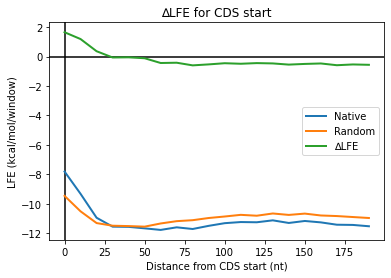

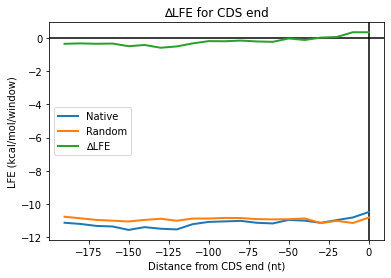

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def plotMeanDLFE(allNativeLFEs, allRandomLFEs, allDeltaLFEs, reference):
    nativeLFEprofile = np.nanmean( np.vstack(allNativeLFEs), axis=0)
    randomLFEprofile = np.nanmean( np.vstack(allRandomLFEs), axis=0)
    deltaLFEprofile  = np.nanmean( np.vstack(allDeltaLFEs),  axis=0)

    if reference=='begin':
        xRange = range(0,cdsSpan,stepSize)
    elif reference=='end':
        xRange = range(-cdsSpan+stepSize,1,stepSize)
    else:
        assert (False)

    f = plt.subplots()
    plt.axhline(y=0, c='black')
    plt.axvline(x=0, c='black')
    plt.plot(xRange, nativeLFEprofile, lw=2, label='Native')
    plt.plot(xRange, randomLFEprofile, lw=2, label='Random')
    plt.plot(xRange, deltaLFEprofile,  lw=2, label='∆LFE')
    plt.title('∆LFE for CDS {}'.format('start' if reference=='begin' else 'end'))
    plt.ylabel('LFE (kcal/mol/window)')
    plt.xlabel('Distance from CDS {} (nt)'.format('start' if reference=='begin' else 'end'))
    plt.legend();

    print((~np.isnan(np.vstack(allNativeLFEs))).sum(axis=0))
    #print(np.nanmean( np.vstack(allNativeLFEs), axis=0 ))
    
plotMeanDLFE(LFEresultsStart[0], LFEresultsStart[1], LFEresultsStart[2], reference='begin')
plotMeanDLFE(LFEresultsEnd[0],   LFEresultsEnd[1],   LFEresultsEnd[2],   reference='end')